In [1]:
import gc
import joblib
import numpy as np
import pandas as pd
import pickle
import enum

from collections import defaultdict
from concurrent.futures import ProcessPoolExecutor
from pathlib import Path
from scipy.sparse import coo_matrix, dok_matrix, lil_matrix, csr_matrix, bsr_matrix
from tqdm import tqdm



from sklearn.model_selection import train_test_split
import lightgbm as lgb
from collections import deque
import json


from pylab import rcParams
from sklearn.metrics import roc_auc_score
from scipy import sparse
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [2]:
#change the input path
input_path=Path('C:\\Users\\luxin\\iCloudDrive\\UR\\Machine learning\\final\\riiid-test-answer-prediction')

In [3]:
q_df=pd.read_csv(input_path/'questions.csv')
q_df.fillna('-1')

assert len(q_df.question_id.unique())==len(q_df)
q_df['tags']=q_df['tags'].astype(str)
tag_len=q_df['tags'].apply(lambda x: len(x.split(' '))).max()
tags_df=q_df.tags.str.split(' ',expand=True).fillna(-1)
for i in range(tag_len):
    c_name='tag_'+str(i)
    q_df[c_name]=tags_df[i]
q_df['tag']=q_df['tags'].apply(lambda x: str(x).split(' '))
q_df['tag_num']=q_df['tag'].apply(lambda x: len(x))
q_df.head()

,question_id,bundle_id,correct_answer,part,tags,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag,tag_num
0,0,0,0,1,51 131 162 38,51,131,162,38,-1,-1,"[51, 131, 162, 38]",4
1,1,1,1,1,131 36 81,131,36,81,-1,-1,-1,"[131, 36, 81]",3
2,2,2,0,1,131 101 162 92,131,101,162,92,-1,-1,"[131, 101, 162, 92]",4
3,3,3,0,1,131 149 162 29,131,149,162,29,-1,-1,"[131, 149, 162, 29]",4
4,4,4,3,1,131 5 162 38,131,5,162,38,-1,-1,"[131, 5, 162, 38]",4


In [4]:
train_df=pd.read_csv(input_path/'train.csv')


In [5]:
train_q_df = train_df[train_df['content_type_id'] == 0]
c_r=train_q_df[['content_id','answered_correctly']].groupby('content_id').sum()/train_q_df[['content_id','answered_correctly']].groupby('content_id').count()#correct rate
c_r.columns=['c_rate']
c_r['id']=c_r.index
c_r['num']=train_q_df[['content_id','answered_correctly']].groupby('content_id').count().values
c_r['c_num']=train_q_df[['content_id','answered_correctly']].groupby('content_id').sum().values

In [6]:
tags=c_r.join(q_df)[['c_rate', 'num', 'c_num']].fillna('-1').values
tag_count=defaultdict(lambda:0)
for tag in tags.flat:
    if tag!='nan' and int(tag)>0:
        tag_count[tag]=tag_count[tag]+1

In [7]:
q_df=q_df.join(c_r)

In [8]:
q_data=q_df[['tag_0','tag_1','tag_2','tag_3','tag_4','tag_5','c_rate','part']].fillna('0')

In [9]:
x=q_data
from sklearn import preprocessing
t= preprocessing.StandardScaler().fit(x)
x=t.transform(x)
x.max(axis=0)

array([ 1.92069438,  2.5232192 ,  3.26273156,  4.22884457,  6.18852657,
       12.75751224,  1.76641209,  1.65510264])

In [10]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=21, random_state=0).fit(x)
label=kmeans.labels_

In [11]:
q_df['tag_group']=kmeans.labels_

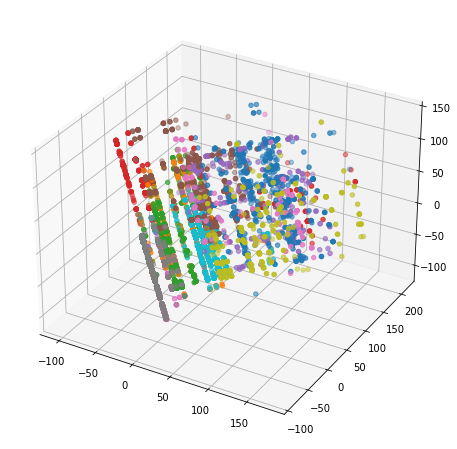

In [12]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
pca = PCA(3)

#Transform the data
df = pca.fit_transform(q_data)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
for i in range(22):
    data=df[label==i]
    ax.scatter(data[:,2],data[:,0],data[:,1])
plt.savefig('taggroup.png')

In [13]:
q_df.to_csv('question_pre.csv')

In [14]:
#change the input path
input_path=Path('C:\\Users\\luxin\\iCloudDrive\\UR\\Machine learning\\final\\riiid-test-answer-prediction')

## Public functions

In [15]:
def col_cat(df,col):
    code_dict={}
    for label,value in enumerate(df[col].unique()):
        label=label+1
        code_dict[value]=label  
    return df[col].apply(lambda x: code_dict[x])

In [16]:
def df_dict(df,id_col,cols,data_dict):
    for col in cols:
        data_dict[col]=dict()
        for i in range(len(df)):
            data_dict[col][df[id_col][i]]=df[col][i]
    

## Questions

In [17]:
q_df=pd.read_csv(input_path/'question_pre.csv')
assert len(q_df.question_id.unique())==len(q_df)
q_df['tags']=q_df['tags'].astype(str)
tag_len=q_df['tags'].apply(lambda x: len(x.split(' '))).max()
tags_df=q_df.tags.str.split(' ',expand=True).fillna(-1)
for i in range(tag_len):
    c_name='tag_'+str(i)
    q_df[c_name]=tags_df[i]
q_df['tag']=q_df['tags'].apply(lambda x: str(x).split(' '))
q_df['tag_num']=q_df['tag'].apply(lambda x: len(x))
q_df.head()

,question_id,bundle_id,correct_answer,part,tags,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag,tag_num,c_rate,id,num,c_num,tag_group,qp
0,0,0,0,1,131 162 38 51,131,162,38,51,-1,-1,"[131, 162, 38, 51]",4,0.907721,0,6903,6266,1,0.000069
1,1,1,1,1,131 36 81,131,36,81,-1,-1,-1,"[131, 36, 81]",3,0.890646,1,7398,6589,20,0.000074
2,2,2,0,1,101 131 162 92,101,131,162,92,-1,-1,"[101, 131, 162, 92]",4,0.554281,2,44905,24890,17,0.000452
3,3,3,0,1,131 149 162 29,131,149,162,29,-1,-1,"[131, 149, 162, 29]",4,0.779437,3,22973,17906,17,0.000231
4,4,4,3,1,131 162 38 5,131,162,38,5,-1,-1,"[131, 162, 38, 5]",4,0.613215,4,31736,19461,1,0.000320


In [18]:
q_df.tag_num.mean()

2.2918731050802337

In [19]:
assert q_df.isna().sum().sum() == 0

In [20]:
q_dict=dict()
df_dict(q_df,'question_id',['bundle_id','part','correct_answer','tag','tag_0','tag_1','tag_2','tag_3','tag_4','tag_5','tag_num','tag_group','qp','c_rate'],q_dict)

In [21]:
q_dict.keys()

dict_keys(['bundle_id', 'part', 'correct_answer', 'tag', 'tag_0', 'tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_num', 'tag_group', 'qp', 'c_rate'])

## Tag Group

In [22]:
tgg_df=pd.read_csv(input_path/'tag_group.csv')
tgg_df.head()

,tag_group,tgn,tgcn,tgcr,tgp
0,0,5340928,2957917,0.553821,0.053801
1,1,2612284,2159411,0.826637,0.026315
2,2,895178,693719,0.774951,0.009017
3,3,6844831,5535531,0.808717,0.068951
4,4,6274734,4422091,0.704746,0.063208


In [23]:
tgg_dict=dict()
df_dict(tgg_df,'tag_group',['tgp','tgcr'],tgg_dict)

## Lectures

In [24]:
l_df=pd.read_csv(input_path/'lectures.csv')

In [25]:
#convert type_of to number label
# types=l_df.type_of.unique().tolist()
# type_label=dict(zip(types,range(len(types))))
# l_df['to']=l_df['type_of'].apply(lambda x: type_label[x])
# l_df['type_of'] = pd.Categorical(l_df['type_of'])

In [26]:
l_df['to']=col_cat(l_df,'type_of')

In [27]:
assert l_df.isna().sum().sum() == 0

In [28]:
l_df.head()

,lecture_id,tag,part,type_of,to
0,89,159,5,concept,1
1,100,70,1,concept,1
2,185,45,6,concept,1
3,192,79,5,solving question,2
4,317,156,5,solving question,2


In [29]:
l_dict=dict()
df_dict(l_df,'lecture_id',['tag','part','to'],l_dict)

## Interaction

In [30]:
train_df=pd.read_csv(input_path/'train.csv')

In [31]:
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [32]:
train_df=train_df.sort_values(by=['user_id', 'timestamp'])

In [33]:
Col=dict(zip(train_df.columns,range(len(train_df.columns))))

In [34]:
train_df['pqhe']=train_df['prior_question_had_explanation'].fillna(False)
train_df['pqhe']=col_cat(train_df,'pqhe')-1
pqet_avg=train_df['prior_question_elapsed_time'].mean()
train_df['pqet']=train_df['prior_question_elapsed_time'].fillna(pqet_avg)

In [35]:
#appearance probability of each questions
train_q_df = train_df[train_df['content_type_id'] == 0]
qp_d = (train_q_df['content_id'].value_counts() / len(train_q_df)).to_dict()


In [36]:
# c_r=train_q_df[['content_id','answered_correctly']].groupby('content_id').sum()/train_q_df[['content_id','answered_correctly']].groupby('content_id').count()#correct rate
# c_r.columns=['c_rate']
# c_r['id']=c_r.index
# c_r['num']=train_q_df[['content_id','answered_correctly']].groupby('content_id').count().values
# c_r['c_num']=train_q_df[['content_id','answered_correctly']].groupby('content_id').sum().values

In [37]:
# df_dict(c_r,'id',['num','c_num','c_rate'],q_dict)

In [38]:
q_df['qp']=q_df.question_id.apply(lambda x: qp_d[x])
df_dict(q_df,'question_id',['qp'],q_dict)

In [39]:
# tags=c_r.join(q_df)[['tag_0','tag_1','tag_2','tag_3','tag_4','tag_5','num']].fillna('-1').values
# tag_count=defaultdict(lambda:0)
# for tag in tags.flat:
#     if tag!='nan' and int(tag)>0:
#         tag_count[tag]=tag_count[tag]+1

In [40]:
avg_c_rate=train_q_df['answered_correctly'].sum()/train_q_df['answered_correctly'].count()

## Test

In [41]:
train_df.columns
# 'row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id','task_container_id', 'user_answer', 'answered_correctly','prior_question_elapsed_time', 'prior_question_had_explanation'
  

Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation', 'pqhe',
       'pqet'],
      dtype='object')

In [42]:
f_cols=[
    #basic
    'cu',#count of question of this user
    'is_first',
    #timestamp
    'ts',
    'ts_mod_day',
    'ts_mod_week',
    'ts_day',
    #question
    'question_id',
#     'task_container_id',
    'container_ord', #organ in the container
    'part',
    'bundle_id',
    'tgg',#tag group
    'qtag0',
    'tag_num',#number of tags
    'qp', #appear probability
    'qc_r',#correct rate
    #question user cum
    #Calc cumsum for question numbers
#     cum_sum',
    'cum_csum',
    'cum_crate',
    'sum_avgt',#average cosume time
    'a_ans',#already answerewd: 0 no 1 incorrect 2 correct
    #prior answer
    'pq',
    'ptag0',
    'ppart',
    'pbundle',
    'ptgg',
    'pq_correct',#whether prior answered correct
    'pqet',#remember to divide task_container num
    'pqhe',
    'tsli', #prior to current
    'tsli2',
    'tsli3',
    'clipped_tsli',#20 minutes clipped
    #for the last 5 questions
    'roll_num',
    'roll_1',
    'roll_2',
    'roll_3',
    'roll_4',
    'roll_5',
    'roll_6',
    'roll_7',
    'roll_8',
    'roll_9',
    'roll_10',
    #taggroup
    'tgp',
    'tgcr',
    'tgg_num',#user question number under this taggroup
    'tgg_cnum',#user correct question number under this taggroup
    #lecture
    'l_num',#lecture sum
    'l_tag_num',#l_num in the tag
    'l1_num',#l_num in concept
    'l2_num',#l_num in solve questions
    'l_part_num',
    #diagnostic
    'is_d',
    #part
    'pp_num',#paid part ratio 1,3,4,6,7
    'lp_num',#listening part ratio 1,2,3,4
    'pp_ratio',#paid part ratio 1,3,4,6,7
    'lp_ratio',#listening part ratio 1,2,3,4
    #answer
    'answered_correctly',
    'user_answer'
]
FCol=dict(zip(f_cols,range(len(f_cols))))
Col=dict(zip(train_df.columns,range(len(train_df.columns))))

In [43]:
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,pqhe,pqet
0,0,0,115,5692,0,1,3,1,NaN,NaN,0,25423.810043
1,1,56943,115,5716,0,2,2,1,37000.0,False,0,37000.000000
2,2,118363,115,128,0,0,0,1,55000.0,False,0,55000.000000
3,3,131167,115,7860,0,3,0,1,19000.0,False,0,19000.000000
4,4,137965,115,7922,0,4,1,1,11000.0,False,0,11000.000000


In [44]:
test_df=train_df[0:100000]
test_df=test_df.sort_values(by=['user_id', 'timestamp'])
test_data=test_df.values

In [45]:
print(Col.keys())
print(FCol.keys())

dict_keys(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id', 'task_container_id', 'user_answer', 'answered_correctly', 'prior_question_elapsed_time', 'prior_question_had_explanation', 'pqhe', 'pqet'])
dict_keys(['cu', 'is_first', 'ts', 'ts_mod_day', 'ts_mod_week', 'ts_day', 'question_id', 'container_ord', 'part', 'bundle_id', 'tgg', 'qtag0', 'tag_num', 'qp', 'qc_r', 'cum_csum', 'cum_crate', 'sum_avgt', 'a_ans', 'pq', 'ptag0', 'ppart', 'pbundle', 'ptgg', 'pq_correct', 'pqet', 'pqhe', 'tsli', 'tsli2', 'tsli3', 'clipped_tsli', 'roll_num', 'roll_1', 'roll_2', 'roll_3', 'roll_4', 'roll_5', 'roll_6', 'roll_7', 'roll_8', 'roll_9', 'roll_10', 'tgp', 'tgcr', 'tgg_num', 'tgg_cnum', 'l_num', 'l_tag_num', 'l1_num', 'l2_num', 'l_part_num', 'is_d', 'pp_num', 'lp_num', 'pp_ratio', 'lp_ratio', 'answered_correctly', 'user_answer'])


In [46]:
%%time
diagnostic_questions=[[7900],[7876],[175],[1278],[2063, 2064, 2065],[2063, 2064, 2065],[2063, 2064, 2065],[3363, 3364, 3365],[3363, 3364, 3365],[3363, 3364, 3365],[2946, 2947, 2948],[2946, 2947, 2948],[2946, 2947, 2948],[2593, 2594, 2595],[2593, 2594, 2595], [2593, 2594, 2595], [4492], [4120], [4696], [6116], [6173], [6370], [6877, 6878, 6879, 6880], [6877, 6878, 6879, 6880], [6877, 6878, 6879, 6880], [6877, 6878, 6879, 6880], [7216, 7217, 7218, 7219], [7216, 7217, 7218, 7219], [7216, 7217, 7218, 7219], [7216, 7217, 7218, 7219]]
diagnostic_questions2=[128, 7860, 7922, 156, 51, 50, 7896, 7863, 152, 104, 108, 7900, 7901, 7971, 25, 183, 7926, 7927, 4, 7984, 45, 185, 55, 7876, 6, 172, 7898, 175, 100, 7859]

train=[]
cu_dict=defaultdict(lambda:0)#user number of questions
ccu_dict=defaultdict(lambda:0)#user number of correct questions
cpu_dict=defaultdict(lambda: defaultdict(lambda:0))#user number of part
last_ts=defaultdict(lambda:0)
ctgu_dict=defaultdict(lambda: defaultdict(lambda:0))#user number on the tag group
cctgu_dict=defaultdict(lambda: defaultdict(lambda:0))#user correct number on the tag group
u_tc_dict=defaultdict(lambda:0) #number of questions in current task container
u_ptc_dict=defaultdict(lambda:-1) #prior task container
u_pq_dict=defaultdict(lambda:-1) #prior task container
u_qet_dict=defaultdict(lambda:defaultdict(lambda:25423)) # question elapsed time,use userid as key and tcid as sub-key
u_hist_dict=defaultdict(lambda: defaultdict(lambda:0)) #question history of user with answer
u_tsli_dict=defaultdict(lambda: 0) #temp tsli
#lecture dict
u_l_dict=defaultdict(lambda:0)
u_ltag_dict=defaultdict(lambda: defaultdict(lambda:0))
u_lpart_dict=defaultdict(lambda: defaultdict(lambda:0))
u_lto_dict=defaultdict(lambda: defaultdict(lambda:0))
u_10pre_dict=defaultdict(lambda:deque([0,0,0,0,0,0,0,0,0,0]))
u_3pt_dict=defaultdict(lambda:deque([0,0,0]))#pre timestamp
pay_part=[1,2,4,6,7]
listen_part=[1,2,3,4]


CPU times: total: 0 ns
Wall time: 0 ns


In [47]:
def update_data(data,cu_dict,ccu_dict,cpu_dict,last_ts,ctgu_dict,cctgu_dict,u_tc_dict,u_ptc_dict,u_pq_dict,u_qet_dict,u_hist_dict,u_tsli_dict,u_l_dict,u_ltag_dict,u_lpart_dict,u_lto_dict,u_10pre_dict,u_3pt_dict): 
    diagnostic_questions=[[7900],[7876],[175],[1278],[2063, 2064, 2065],[2063, 2064, 2065],[2063, 2064, 2065],[3363, 3364, 3365],[3363, 3364, 3365],[3363, 3364, 3365],[2946, 2947, 2948],[2946, 2947, 2948],[2946, 2947, 2948],[2593, 2594, 2595],[2593, 2594, 2595], [2593, 2594, 2595], [4492], [4120], [4696], [6116], [6173], [6370], [6877, 6878, 6879, 6880], [6877, 6878, 6879, 6880], [6877, 6878, 6879, 6880], [6877, 6878, 6879, 6880], [7216, 7217, 7218, 7219], [7216, 7217, 7218, 7219], [7216, 7217, 7218, 7219], [7216, 7217, 7218, 7219]]
    diagnostic_questions2=[128, 7860, 7922, 156, 51, 50, 7896, 7863, 152, 104, 108, 7900, 7901, 7971, 25, 183, 7926, 7927, 4, 7984, 45, 185, 55, 7876, 6, 172, 7898, 175, 100, 7859]
    pay_part=[1,2,4,6,7]
    listen_part=[1,2,3,4]
    # tags=['tag_0','tag_1','tag_2','tag_3','tag_4','tag_5']
    train_x=[]
    train_y=[]
    for i,row in enumerate(data):

        is_lecture=row[Col['content_type_id']]
        #only make record for questions,lecture update to features
        user_id=row[Col['user_id']]
        if not is_lecture:
            frow=np.zeros(len(FCol)).astype(np.float64)
            qid=row[Col['content_id']]
            tcid=row[Col['task_container_id']]
            tags=q_dict['tag'][qid]
            part=q_dict['part'][qid]
            tgg=q_dict['tag_group'][qid]
            #update cu
            cu_dict[user_id]+=1
            u_tc_dict[user_id,tcid]+=1
            ctgu_dict[user_id][tgg]+=1
            cpu_dict[user_id][part]+=1
            for tag in tags:
                tag=int(tag)
                frow[FCol['l_tag_num']]+=u_ltag_dict[user_id][tag]
            #update data
            frow[FCol['cu']]=cu_dict[user_id]
            ts=row[Col['timestamp']]
            frow[FCol['ts']]=ts
            #tsli for the prior task container
            if ts-last_ts[user_id]!=0:
                tsli=ts-last_ts[user_id]
                u_tsli_dict[user_id]=tsli
            else:
                tsli=u_tsli_dict[user_id]
            frow[FCol['tsli']]=tsli
            frow[FCol['tsli2']]=ts-u_3pt_dict[user_id][1]
            frow[FCol['tsli3']]=ts-u_3pt_dict[user_id][0]
            frow[FCol['clipped_tsli']]=min(tsli, 1000 * 60 * 20)
            frow[FCol['ts_mod_day']]=(row[Col['timestamp']])%(1000 * 60 * 60 * 24)
            frow[FCol['ts_mod_week']]=(row[Col['timestamp']])%(1000 * 60 * 60 * 24*7)
            frow[FCol['ts_day']]=int(row[Col['timestamp']])/(1000 * 60 * 60 * 24)

            frow[FCol['question_id']]=qid
            frow[FCol['pqhe']]=row[Col['pqhe']]

            frow[FCol['container_ord']]=u_tc_dict[user_id,tcid]
            frow[FCol['part']]=q_dict['part'][qid]
            frow[FCol['bundle_id']]=q_dict['bundle_id'][qid]
            frow[FCol['qp']]=q_dict['qp'][qid]
            frow[FCol['tag_num']]=q_dict['tag_num'][qid]
            frow[FCol['qtag0']]=q_dict['tag_0'][qid]
            frow[FCol['qc_r']]=q_dict['c_rate'][qid]
            frow[FCol['tgg']]=tgg
            #update ccu
            frow[FCol['cum_csum']]=ccu_dict[user_id]
            frow[FCol['cum_crate']]=frow[FCol['cum_csum']]/float(frow[FCol['cu']])
            #update question elapsed time to dict
            ptc=u_ptc_dict[user_id]
            pq=u_pq_dict[user_id]
            if ptc!=-1  and ptc!=tcid:
                u_qet_dict[user_id][ptc]=row[Col['pqet']]/u_tc_dict[user_id,ptc]
            if ptc!=-1:
                frow[FCol['sum_avgt']]=sum(u_qet_dict[user_id].values())/len(u_qet_dict[user_id])
                frow[FCol['pq']]=pq
                frow[FCol['ptag0']]=q_dict['tag_0'][pq]
                frow[FCol['ptgg']]=q_dict['tag_group'][pq]
                frow[FCol['ppart']]=q_dict['part'][pq]
                frow[FCol['pbundle']]=q_dict['bundle_id'][pq]
                frow[FCol['pq_correct']]=u_hist_dict[user_id][pq]-1
                frow[FCol['is_first']]=0
            else:
                frow[FCol['sum_avgt']]=-1
                frow[FCol['is_first']]=1
            u_ptc_dict[user_id]=tcid
            u_pq_dict[user_id]=qid
            frow[FCol['a_ans']]=u_hist_dict[user_id][qid]
            
            frow[FCol['pqet']]=u_qet_dict[user_id][ptc]
            #update last_timestamp,do not update when there is in the same task container
            last_ts[user_id]=row[Col['timestamp']]
            #taggroup stats
            frow[FCol['tgp']]=tgg_dict['tgp'][tgg]
            frow[FCol['tgcr']]=tgg_dict['tgcr'][tgg]
            frow[FCol['tgg_num']]=ctgu_dict[user_id][tgg]
            frow[FCol['tgg_cnum']]=cctgu_dict[user_id][tgg]

            #lecture l_num l_tag_num l_part_num l_1_num l_2_num
            frow[FCol['l_num']]=u_l_dict[user_id]

            frow[FCol['l_part_num']]=u_lpart_dict[user_id][part]

            frow[FCol['l1_num']]=u_lpart_dict[user_id][1]  
            frow[FCol['l2_num']]=u_lpart_dict[user_id][2]  
            #diagnostic
            if frow[FCol['cu']] < 30:          
                if qid in diagnostic_questions[int(frow[FCol['cu']])]:
                    frow[FCol['is_d']] =2
                elif qid == diagnostic_questions2[int(frow[FCol['cu']])]:
                    frow[FCol['is_d']] =1
                    #else 0
            #part ratio
            pp=0
            lp=0
            for p in pay_part:
                pp+=cpu_dict[user_id][p]
            for p in listen_part:
                lp+=cpu_dict[user_id][p]
            frow[FCol['pp_num']]=pp
            frow[FCol['lp_num']]=lp
            frow[FCol['pp_ratio']]=pp/cu_dict[user_id]
            frow[FCol['lp_ratio']]=lp/cu_dict[user_id]
            #roll
            if cu_dict[user_id]<11:
                frow[FCol['roll_num']]=cu_dict[user_id]-1
            else:
                frow[FCol['roll_num']]=10
            for i in range(10):
                frow[FCol['roll_num']+i]=u_10pre_dict[user_id][i]
    #         if len(u_10pre_dict[user_id])>1:
    #             pre_5=np.array(u_5pre_dict[user_id])
    #             pre_10=np.array(u_10pre_dict[user_id])
    #             frow[FCol['roll5_c']]=pre_5.sum(axis=0)[1]
    #             frow[FCol['roll10_c']]=pre_10.sum(axis=0)[1]
    #             frow[FCol['roll5_cr']]=pre_5.sum(axis=0)[1]/pre_5.shape[0]
    #             frow[FCol['roll10_cr']]=pre_10.sum(axis=0)[1]/pre_5.shape[0]
            #append to data
            train_x.append(frow.tolist())
            train_y.append(row[Col['answered_correctly']])

            #update others
            ccu_dict[user_id]+=row[Col['answered_correctly']]
            cctgu_dict[user_id][tgg]+=row[Col['answered_correctly']]
            u_hist_dict[user_id][qid]=row[Col['answered_correctly']]+1
            #append roll deque
    #         u_5pre_dict[user_id].popleft()
    #         u_5pre_dict[user_id].append(row[Col['answered_correctly']])
            u_10pre_dict[user_id].popleft()
            u_10pre_dict[user_id].append(row[Col['answered_correctly']])
            u_3pt_dict[user_id].popleft()
            u_3pt_dict[user_id].append(ts)
    #         if len(u_10pre_dict[user_id])<10:
    #             u_10pre_dict[user_id].append([qid,row[Col['answered_correctly']],row[Col['user_answer']]])
    #         else:
    #             u_10pre_dict[user_id].popleft()
    #             u_10pre_dict[user_id].append([qid,row[Col['answered_correctly']],row[Col['user_answer']]])

        if is_lecture:
            lid=row[Col['content_id']]
            tag=l_dict['tag'][lid]
            part=l_dict['part'][lid]
            to=l_dict['to'][lid]
            u_ltag_dict[user_id][tag]+=1
            u_lpart_dict[user_id][part]+=1
            u_lto_dict[user_id][to]+=1
            u_l_dict[user_id]+=1
    return train_x,train_y
#     return (train,cu_dict,ccu_dict,cpu_dict,last_ts,ctgu_dict,cctgu_dict,u_tc_dict,u_ptc_dict,u_pq_dict,u_qet_dict,u_hist_dict,u_tsli_dict,u_l_dict,u_ltag_dict,u_lpart_dict,u_lto_dict,u_10pre_dict,u_3pt_dict)

In [48]:
# train_x,train_y=update_data(test_data,cu_dict,ccu_dict,cpu_dict,last_ts,ctgu_dict,cctgu_dict,u_tc_dict,u_ptc_dict,u_pq_dict,u_qet_dict,u_hist_dict,u_tsli_dict,u_l_dict,u_ltag_dict,u_lpart_dict,u_lto_dict,u_10pre_dict,u_3pt_dict)

In [49]:

def pre_process(df,cu_dict,ccu_dict,cpu_dict,last_ts,ctgu_dict,cctgu_dict,u_tc_dict,u_ptc_dict,u_pq_dict,u_qet_dict,u_hist_dict,u_tsli_dict,u_l_dict,u_ltag_dict,u_lpart_dict,u_lto_dict,u_10pre_dict,u_3pt_dict):
    data=df.values
    train_x,train_y=update_data(data,cu_dict,ccu_dict,cpu_dict,last_ts,ctgu_dict,cctgu_dict,u_tc_dict,u_ptc_dict,u_pq_dict,u_qet_dict,u_hist_dict,u_tsli_dict,u_l_dict,u_ltag_dict,u_lpart_dict,u_lto_dict,u_10pre_dict,u_3pt_dict)
    return train_x,train_y
#     return (train,cu_dict,ccu_dict,cpu_dict,last_ts,ctgu_dict,cctgu_dict,u_tc_dict,u_ptc_dict,u_pq_dict,u_qet_dict,u_hist_dict,u_tsli_dict,u_l_dict,u_ltag_dict,u_lpart_dict,u_lto_dict,u_10pre_dict,u_3pt_dict)

In [50]:
%%time
#split the data set
bins = np.linspace(train_df.user_id.min()-1, train_df.user_id.max(), num=1000, dtype=np.int32)
dfg = train_df.groupby(pd.cut(train_df.user_id, bins))
groups = [ dfg.get_group(_) for _ in dfg.groups.keys() ]

CPU times: total: 18.5 s
Wall time: 21.9 s


In [51]:
#initial
cu_dict=defaultdict(lambda:0)#user number of questions
ccu_dict=defaultdict(lambda:0)#user number of correct questions
cpu_dict=defaultdict(lambda: defaultdict(lambda:0))#user number of part
last_ts=defaultdict(lambda:0)
ctgu_dict=defaultdict(lambda: defaultdict(lambda:0))#user number on the tag group
cctgu_dict=defaultdict(lambda: defaultdict(lambda:0))#user correct number on the tag group
u_tc_dict=defaultdict(lambda:0) #number of questions in current task container
u_ptc_dict=defaultdict(lambda:-1) #prior task container
u_pq_dict=defaultdict(lambda:-1) #prior task container
u_qet_dict=defaultdict(lambda:defaultdict(lambda:25423)) # question elapsed time,use userid as key and tcid as sub-key
u_hist_dict=defaultdict(lambda: defaultdict(lambda:0)) #question history of user with answer
u_tsli_dict=defaultdict(lambda: 0) #temp tsli
#lecture dict
u_l_dict=defaultdict(lambda:0)
u_ltag_dict=defaultdict(lambda: defaultdict(lambda:0))
u_lpart_dict=defaultdict(lambda: defaultdict(lambda:0))
u_lto_dict=defaultdict(lambda: defaultdict(lambda:0))
u_10pre_dict=defaultdict(lambda:deque([0,0,0,0,0,0,0,0,0,0]))
u_3pt_dict=defaultdict(lambda:deque([0,0,0]))#pre timestamp

In [52]:
#only take 1% data as sample
for i, df in enumerate(groups[0:10]):
    print(i)
    train=[]
    train_x,train_y=pre_process(df,cu_dict,ccu_dict,cpu_dict,last_ts,ctgu_dict,cctgu_dict,u_tc_dict,u_ptc_dict,u_pq_dict,u_qet_dict,u_hist_dict,u_tsli_dict,u_l_dict,u_ltag_dict,u_lpart_dict,u_lto_dict,u_10pre_dict,u_3pt_dict)
    file1=f'train_pre/train_pre_x{i}.pkl'
    file2=f'train_pre/train_pre_y{i}.pkl'
    with open(file1, 'wb') as f:
        pickle.dump(train_x, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open(file2, 'wb') as f:
        pickle.dump(train_y, f, protocol=pickle.HIGHEST_PROTOCOL)


0
1
2
3
4
5
6
7
8
9


## Here we only take 300w data as sample. The whole data set contains 10000w data. 

In [53]:
k=3

In [54]:
for i in tqdm(range(k)):
    file_x=f'train_pre/train_pre_x{i}.pkl'
    datas=pd.DataFrame(pd.read_pickle(file_x))
    if i==0:
        data_x=datas
    else:
        data_x=pd.concat([data_x,datas])
data_x.to_csv('train_x.csv')

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.53s/it]


In [55]:
for i in tqdm(range(k)):
    file_y=f'train_pre/train_pre_y{i}.pkl'
    if i==0:
        data_y=pd.read_pickle(file_y)
    else:
        data_y=data_y+pd.read_pickle(file_y)
pd.DataFrame(data_y).to_csv('train_y.csv')

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 328.86it/s]
